In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

# -------------------------
# Step 1: Generate test sets with varying imbalance
# -------------------------
def create_imbalance_test_sets(df, label_col='Label', imbalance_ratios=[0.01], test_size=0.2, random_state=42):
    positives = df[df[label_col] == 1]
    negatives = df[df[label_col] == 0]

    train_pos, test_pos = train_test_split(positives, test_size=test_size, random_state=random_state)
    train_neg, test_neg = train_test_split(negatives, test_size=test_size, random_state=random_state)
    train_balanced = pd.concat([train_pos, train_neg]).sample(frac=1, random_state=random_state).reset_index(drop=True)

    test_sets = {}
    for ratio in imbalance_ratios:
        n_pos = len(test_pos)
        n_neg = int(n_pos * (1 - ratio) / ratio)
        sampled_neg = test_neg.sample(n=n_neg, replace=False if n_neg <= len(test_neg) else True, random_state=random_state)
        test_set = pd.concat([test_pos, sampled_neg]).sample(frac=1, random_state=random_state).reset_index(drop=True)
        test_sets[ratio] = test_set

    return train_balanced, test_sets

In [18]:
def evaluate_at_threshold(y_true, y_scores, threshold):
    """
    Computes predictions, accuracy, and confusion matrix given a threshold.

    Parameters:
    -----------
    y_true : array-like
        Ground truth binary labels (0/1)
    y_scores : array-like
        Predicted probabilities or scores
    threshold : float
        Decision threshold for classifying positives

    Returns:
    --------
    accuracy : float
        Accuracy of thresholded predictions
    cm : ndarray of shape (2, 2)
        Confusion matrix: [[TN, FP], [FN, TP]]
    y_pred : ndarray
        Predicted labels
    """
    y_pred = (y_scores >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return acc, cm, y_pred


In [32]:
def find_optimal_threshold(y_true, y_scores, method='f1'):
    """
    Find the optimal threshold based on a specified method.
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth binary labels (0/1)
    y_scores : array-like
        Predicted probabilities or scores from the model
    method : str
        Optimization criterion: 'precision' (default), or 'f1'

    Returns:
    --------
    threshold : float
        Optimal decision threshold
    precision : float
        Precision at the optimal threshold
    recall : float
        Recall at the optimal threshold
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    if method == 'f1':
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_idx = np.argmax(f1_scores)
    elif method == 'precision':
        best_idx = np.argmax(precision[:-1])  # exclude last precision point (thresholds shorter by 1)
    else:
        raise ValueError("Unsupported method. Use 'precision' or 'f1'.")

    best_threshold = thresholds[best_idx]
    return best_threshold, precision[best_idx], recall[best_idx]


In [20]:
def evaluate_models_on_tests(train_df, test_sets, feature_cols, label_col='Label', random_state=42):
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=random_state),
        'SVM': SVC(probability=True, random_state=random_state),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=random_state)
    }

    results = []

    # display(train_df[feature_cols])
    # display(train_df[label_col])
    # print(train_df[label_col].unique())
    # print(train_df[label_col].dtype)
    # print(train_df[label_col].isna().sum())

    for model_name, model in models.items():
        model.fit(train_df[feature_cols], train_df[label_col])

        for ratio, test_df in test_sets.items():
            y_true = test_df[label_col]
            y_scores = model.predict_proba(test_df[feature_cols])[:, 1]
            auroc = roc_auc_score(y_true, y_scores)
            auprc = average_precision_score(y_true, y_scores)
            
            best_threshold, _, _ = find_optimal_threshold(y_true, y_scores)

            results.append({
                'Model': model_name,
                'PosRatio': ratio,
                'AUROC': auroc,
                'AUPRC': auprc
            })

        print(best_threshold)
        acc, cm, y_pred = evaluate_at_threshold(y_true, y_scores, best_threshold)

        print(f"{model_name} accuracy at threshold {best_threshold:.2f}: {acc:.3f}")
        print(f"{model_name} confusion matrix at threshold {best_threshold:.2f}:")
        print(cm)

        best_threshold = 0.5
        acc, cm, y_pred = evaluate_at_threshold(y_true, y_scores, best_threshold)

        print(f"{model_name} accuracy at threshold {best_threshold:.2f}: {acc:.3f}")
        print(f"{model_name} confusion matrix at threshold {best_threshold:.2f}:")
        print(cm)

    return pd.DataFrame(results)

In [21]:
def plot_all_models(results_df):
    results_df = results_df.sort_values('PosRatio', ascending=False)

    for metric in ['AUROC', 'AUPRC']:
        plt.figure()
        for model_name in results_df['Model'].unique():
            subset = results_df[results_df['Model'] == model_name]
            plt.plot(subset['PosRatio'], subset[metric], marker='o', label=model_name)
        # plt.xscale('log')
        plt.xlabel('Positive Class Ratio')
        plt.ylabel(metric)
        plt.title(f'{metric} vs Class Imbalance')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{metric}_class_imbalance_test.png", dpi=300)
        plt.show()

In [22]:
df1 = pd.read_csv('balanced_fold_1.csv')
df1.columns

Index(['Unnamed: 0', 'global_index', 'scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_CP_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation', 'Same_Complex',
       'Test'],
      dtype='object')

In [23]:
data = pd.DataFrame(columns = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation', 'Same_Complex'])

for i in range(5):
    num = str(i + 1)
    df = pd.read_csv(f'balanced_fold_{num}.csv').drop(columns=['Unnamed: 0', 'global_index', 'scGPT_CP_embeddings_Cosine_Similarity', 'Test'])

    data = pd.concat([data, df])

data = data.dropna().drop_duplicates()

In [24]:
data['Same_Complex'] = data['Same_Complex'].astype(int)


In [25]:
data['Same_Complex'].dtype

dtype('int64')

In [26]:
data

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex
1,0.068281,0.095641,-0.003973,0.024002,0.026690,0.001519,0.053231,0.512591,0.124054,0.855950,0.895115,0.860782,0.258649,0
2,-0.068618,0.055220,-0.012644,-0.054653,0.104500,-0.025205,0.029771,0.296399,0.046220,0.801278,0.876071,0.799759,0.280591,0
3,0.055430,0.089606,0.093886,0.092885,-0.027436,0.014669,-0.032916,0.348519,0.160719,0.728447,0.846240,0.745176,0.268969,0
4,0.064023,-0.010588,-0.029586,-0.129990,-0.106961,-0.082286,-0.060440,0.204620,0.125283,0.631981,0.731705,0.645047,0.229455,0
5,-0.075059,0.077444,-0.056709,-0.019634,-0.143998,-0.029401,-0.076979,0.282250,0.215286,0.769158,0.832823,0.794798,0.098947,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19857,0.026027,-0.017016,-0.044468,0.008732,-0.002609,-0.035154,0.012923,0.285864,0.138036,0.811203,0.852404,0.786145,0.194006,0
19858,-0.013131,-0.001935,-0.102259,-0.035392,-0.035508,-0.023197,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0
19859,0.021105,0.015475,0.001706,0.054092,0.109003,-0.046050,0.004031,0.114882,0.069295,0.556203,0.671250,0.403060,0.187668,0
19860,0.081903,0.055526,-0.019540,0.000730,0.058350,-0.042125,0.087813,0.531043,0.242083,0.677403,0.646955,0.561521,-0.038994,0


In [27]:
feature_columns = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

In [28]:
train_bal, test = create_imbalance_test_sets(data, label_col = 'Same_Complex')

In [29]:
train_bal[feature_columns]

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation
0,0.052081,0.292116,0.058386,0.012151,0.011608,0.032094,0.087304,0.466560,0.195489,0.864232,0.908085,0.878926,0.431166
1,0.070564,0.025253,0.009004,-0.018224,-0.025990,-0.021374,0.041462,-0.005816,0.232857,0.644982,0.617807,0.181275,0.175486
2,0.033780,0.042241,-0.025290,-0.031840,0.030553,-0.026757,0.085788,0.328588,0.329865,0.467501,0.422862,0.440419,0.347889
3,-0.089903,0.055746,0.053657,0.061373,0.182370,0.021443,0.135769,0.334882,0.201289,0.801670,0.849896,0.817390,0.295915
4,0.242733,0.297981,0.154687,0.184148,0.313715,0.114825,0.335325,0.145349,0.151457,0.730537,0.767013,0.793770,-0.183360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47170,-0.002793,0.101565,0.065469,0.055901,0.084629,0.079889,0.035041,0.468608,0.183148,0.796189,0.845924,0.748846,0.081604
47171,0.061773,0.217058,0.052963,-0.001729,0.109505,0.045701,0.015092,0.457252,0.189888,0.728004,0.813615,0.733765,0.628892
47172,0.013657,0.132501,-0.008145,0.064799,-0.033404,0.014420,-0.085341,0.416264,0.179480,0.775225,0.832577,0.793824,-0.005270
47173,0.033895,0.121334,-0.007397,0.005951,0.244353,0.005972,0.145176,0.481642,0.162513,0.809121,0.845429,0.841491,0.570066


In [30]:
train_bal['Same_Complex'].dtype

dtype('int64')

In [33]:
results_df = evaluate_models_on_tests(train_bal, test, feature_columns, label_col='Same_Complex')

0.8269375593353679
LogisticRegression accuracy at threshold 0.83: 0.992
LogisticRegression confusion matrix at threshold 0.83:
[[196174    439]
 [  1186    800]]
LogisticRegression accuracy at threshold 0.50: 0.972
LogisticRegression confusion matrix at threshold 0.50:
[[191876   4737]
 [   803   1183]]
0.9289884786332201
SVM accuracy at threshold 0.93: 0.992
SVM confusion matrix at threshold 0.93:
[[196077    536]
 [  1128    858]]
SVM accuracy at threshold 0.50: 0.977
SVM confusion matrix at threshold 0.50:
[[192823   3790]
 [   780   1206]]
0.86
RandomForest accuracy at threshold 0.86: 0.993
RandomForest confusion matrix at threshold 0.86:
[[196364    249]
 [  1213    773]]
RandomForest accuracy at threshold 0.50: 0.979
RandomForest confusion matrix at threshold 0.50:
[[193129   3484]
 [   774   1212]]


In [45]:
results_df

,Model,PosRatio,AUROC,AUPRC
0,LogisticRegression,0.50,0.924293,0.934816
1,LogisticRegression,0.20,0.919563,0.822543
2,LogisticRegression,0.10,0.920702,0.737493
3,LogisticRegression,0.05,0.920354,0.647236
4,LogisticRegression,0.01,0.919974,0.430411
5,SVM,0.50,0.924717,0.936895
6,SVM,0.20,0.920475,0.832901
7,SVM,0.10,0.921691,0.754319
8,SVM,0.05,0.921304,0.672255
9,SVM,0.01,0.921102,0.481113


In [64]:
results_df.to_csv('balanced_train_imbalanced_test_results.csv', index=False)

In [2]:
results_df = pd.read_csv('balanced_train_imbalanced_test_results.csv')

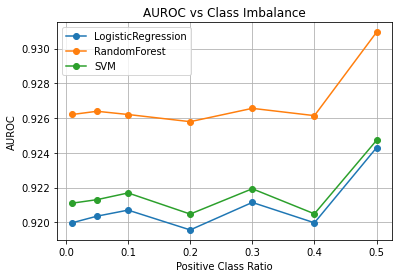

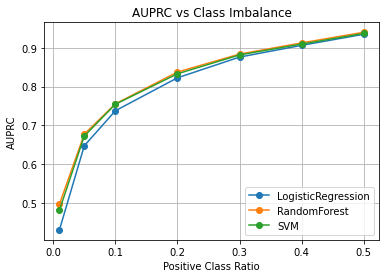

In [7]:
plot_all_models(results_df)